# CS5841 MNIST with Naive Bayes and Logistic Regression
## Wei Qian, Zhiyuan Lu

In this assignment, we build Naive Bayes and Logistic Regression classifiers for the MNIST data set. 

 - MNIST (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is very commonly used for training the image recognition systems. It has got 60,000 training images, and 10,000 testing images.​ ​Each​ ​image​ ​is​ ​28x28,​ ​784​ ​pixels​ ​in​ ​size.
 
 - Naive Bayes classifier is a simple, yet effective and commonly-used, machine learning classifier. It is a probabilistic classifier that makes classifications using the Maximum A Posteriori decision rule in a Bayesian setting. 
 
 - Logistic regression is the appropriate regression analysis to conduct when the dependent variable is binary.

---
Preprocess the datafile downloaded from MNIST. Read the file information and decode the image file into pixel data, label file into real number. Then convert the 28x28 images to each has a very long vector for 784 features.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def decode_idx3_ubyte(filename):
    bin_data = open(filename, 'rb').read()
 
    # decode header info
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic number:%d, image number: %d, image size: %d*%d' % (magic_number, num_images, num_rows, num_cols))
 
    # decode dataset
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images
 
def decode_idx1_ubyte(filename):
    bin_data = open(filename, 'rb').read()
 
    # decode header info
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic number:%d, image number: %d' % (magic_number, num_images))
 
    # decode dataset
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

if __name__ == '__main__':
    train_image = decode_idx3_ubyte('train-images-idx3-ubyte')
    train_label = decode_idx1_ubyte('train-labels-idx1-ubyte')
    test_image = decode_idx3_ubyte('t10k-images-idx3-ubyte')
    test_label = decode_idx1_ubyte('t10k-labels-idx1-ubyte')
     
    # change train_image and test_image to numpy array x*784    
    trainX = np.asarray([np.reshape(x,(784)) for x in train_image])
    train_label = np.asarray(train_label)
    testX = np.asarray([np.reshape(x,(784)) for x in test_image])
    testY_label = np. asarray(test_label)
    print("Decode and transfer done!")
    

magic number:2051, image number: 60000, image size: 28*28
magic number:2049, image number: 60000
magic number:2051, image number: 10000, image size: 28*28
magic number:2049, image number: 10000
Decode and transfer done!


---
Part 1. Build a Naive Bayes classifier for the the MNIST data set and test it on the test data set. 

Likelihood probability follows Gaussian Distribution and we assume the prior probability of each class is equal, hence: $$P(c|x)=\frac{P(x|c)P(c)}{P(x)}\approx\prod_{i=1}^{784} P(x_i|c)$$

 - Encapsulate the Naive Bayes classifier to a class, initialize the variables for traing data and testing data
 - "predict" function classifies the test input data. First, separate the classes and compute mean and std for each class. For each case, compute the likelihood in each class with Gaussian Distribution. And multiply all the likelihood probabilities to the posterior probability
 - "confusion_matrix" gives the confusion matrix for the testing result, calculate the overall accuracy, accuracy for each digit, and plot corresponding tables.
 - "cross_validation" used for computing the mean error for different smoothing for invaild variance.
 - "show_image" shows the likelihood probability as an image with 28x28 scale

In [2]:
class naive_bayes:
    def __init__(self, trainX, train_label, testX, test_label):
        self.n_class=np.unique(train_label) # find the unique elements of train_label
        self.x_train=trainX
        self.y_train=train_label
        self.x_test=testX
        self.y_test=test_label
            
    def predict(self, smoothing):
        self.mean, self.std, self.priors=[], [], []
        for c in self.n_class:
            sep=(self.y_train==c) # separate y_train by class c
            self.priors.append(len(self.y_train[sep])/len(self.y_train)) # the prior probility of class c
            self.mean.append(np.mean(self.x_train[sep],axis=0)) # every mean in class c
            self.std.append(np.std(self.x_train[sep],axis=0)) # every std in class c   
   
        self.pred=[] # predication of test 
        self.likelihood=[] # likelihood of every pixel for each test
        for x in self.x_test:
            classifier=[] # probability of c given x
            likeli=[] # probability of x_i given c
            for i, c in enumerate(self.n_class):
                mean=self.mean[i]
                var=np.square(self.std[i])+smoothing
                prob=1/np.sqrt(2*np.pi*var)*np.exp(-np.square(x-mean)/(2*var))
                res=np.sum(np.log(prob)) # use sum of log instead of multiply to keep some context, no need prior since we assume they are all equal
                
                classifier.append(res)
                likeli.append(prob)
            
            self.pred.append(np.argmax(classifier)) # the maximum probability as predicition result
            self.likelihood.append(likeli)
        
    def confusion_matrix(self):
        cm=confusion_matrix(self.y_test,self.pred)
        all_accu=(sum(np.diagonal(cm))/len(self.y_test))*100 # all accuary, add all correct number in diagonal in confusion matrix
        digit_accu=np.zeros(shape=(len(self.n_class),2))
        for i in range(len(cm)):
            digit_accu[i,0]=self.n_class[i]
            digit_accu[i,1]=round(cm[i,i]/np.sum(cm[i,:])*100,2) # digit accuary, correct divided by all number for a digit
        
        print("Naive Bayes Classifier Confusion Matrix (Actual vs. Prediction)")
        ax=plt.subplot()
        columns=[]
        rows=[]
        colors=[]
        for i in self.n_class:
            columns.append(i)
            rows.append(i)
            colors.append("#E0E0E0")
        cm_table=ax.table(cellText=cm,colLabels=columns,rowLabels=rows,loc='center',colColours=colors, rowColours=colors)
        cm_table.auto_set_font_size(False)
        cm_table.set_fontsize(12)
        cm_table.scale(1.2, 3)
        ax.axis("off")
        plt.show()
        
        print("Naive Bayes Classifier Digit Accuracy")
        bx=plt.subplot()
        columns=["Digit","Accuracy for Each Digit %"]
        digit_table=bx.table(cellText=digit_accu,colLabels=columns,loc='center',colColours=colors)
        digit_table.auto_set_font_size(False)
        digit_table.set_fontsize(12)
        digit_table.scale(1,2)
        bx.axis("off")
        plt.show()
        
        print("Naive Bayes Classifier Overall Accuracy: %.2f%%" %(all_accu))
    
    def cross_validation(self,smoothings,folds):
        kf=KFold(n_splits=folds)
        test_error_rate=[]
        for s in smoothings:
            error_rate=0
            for train_index, test_index in kf.split(self.x_train):
                #print("TRAIN:", train_index, "TEST:", test_index)
                x_train_cv, x_test_cv = self.x_train[train_index], self.x_train[test_index]
                y_train_cv, y_test_cv = self.y_train[train_index], self.y_train[test_index]
                nb_cv=naive_bayes(x_train_cv,y_train_cv,x_test_cv,y_test_cv)
                nb_cv.predict(s)
                cm=confusion_matrix(y_test_cv,nb_cv.pred)
                error_rate+=(1-sum(np.diagonal(cm))/len(y_test_cv))*100 # sum the diagonal of confusion matrix, the number of correct prediction
            
            test_error_rate.append(error_rate/folds) # cross validation mean error rate
        
        fig=plt.figure(figsize=(7,4))
        bx=fig.add_axes([0,0,1,1])
        bx.plot(smoothings,test_error_rate,'-o')
        bx.set_xticks(smoothings)
        bx.set_xlabel('Smoothings',fontsize=12)
        bx.set_ylabel('Error Rate %',fontsize=12)
        plt.title("Cross Validation for Smoothings")
        plt.show()
        
        best_error_rate=np.min(test_error_rate)
        best_smoothing=smoothings[np.argmin(test_error_rate)]
        print("Best smoothing is %d for cross validation error %.2f%%." %(best_smoothing,best_error_rate))
        
        return best_smoothing
    
    def show_image(self,imageData):
        classes=[]
        for i in range(len(self.n_class)):
            classes.append("P(x|c="+str(i)+")")    
        plt.subplots(figsize=(20,2))
        for i in range(len(classes)):
            plt.subplot(1,len(classes),i+1)
            plt.imshow(imageData[i].reshape((28,28))) # reshape the prob to 28*28 image
            plt.axis("off")
            plt.title(classes[i])
        
        plt.show()
        

---
For some margin pixels in an image, the mean and standrad standard deviation could be 0 and it is misleading to calculate the likehood probability since multiply all is equal to 0. Thus, we can add a smoothing variable to the variance to figure this problem. In order to confirm the appropriate smoothing, we use cross validation. From the std array in naive_bayes class, we can also set an interval first.

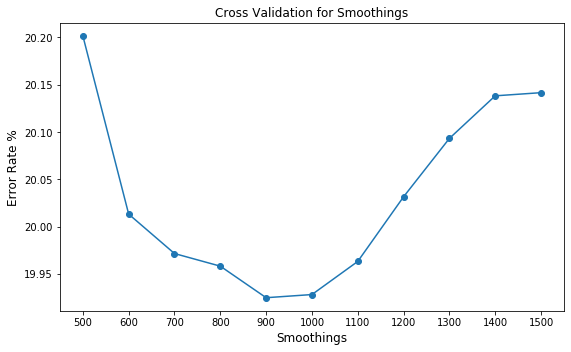

Best smoothing is 900 for cross validation error 19.93%.


In [3]:
smoothings=list(range(500,1600,100))
nb_s=naive_bayes(trainX,train_label,testX,test_label)
best_smoothing=nb_s.cross_validation(smoothings,5) # 5-flod cross validation to find best smoothing

The following figure shows the testing error for different smoothings. X-axis is the smoothings range from 500 to 1600 with 100 interval, y-axis the corresponding testing error for a smoothing. We can conclude that 900 has approximately the lowest cross validation error.

---
When we find the best smoothing for the variance, we can predict the testing data and provide a confusion matrix, accuracy for each digit, and overall accuracy. The confusion matrix summaries the prediction results on this classifier. Overall accurancy is based on the diagonal data in confusion matrix since the diagonal is the correct classifier for each class. Digit accurancy is also based on the rows in confusion matrix because the summation of a row the total number that a class appeared in the testing data.

Naive Bayes Classifier Confusion Matrix (Actual vs. Prediction)


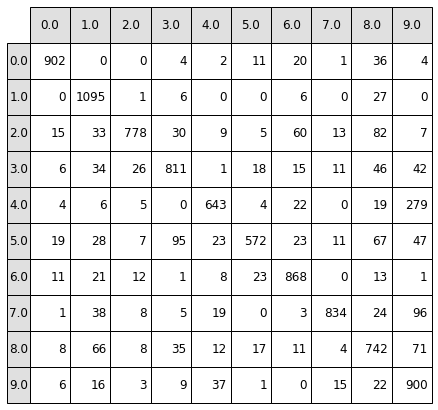

Naive Bayes Classifier Digit Accuracy


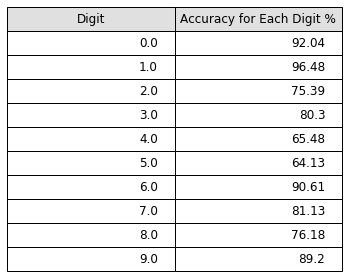

Naive Bayes Classifier Overall Accuracy: 81.45%


In [4]:
nb=naive_bayes(trainX,train_label,testX,test_label)
nb.predict(best_smoothing)
nb.confusion_matrix()

The first table is confusion matrix. The confusion matrix summaries the prediction results on this classifier. The number of correct and incorrect predictions are summarized with count values and broken down by each class. Each row of the matrix corresponds to a predicted class, each column of the matrix corresponds to an actual class. For example, in first row, 0 is the class, 0 to 0 is the correct classifier that has 902, 0 to 8 is the incorrect classider that has 36.

The second table is the accuracy for each digit, each row is the digit number and its accuracy in percentage.

COMMENT : From the the accuarcy data for each digit and overall accurancy, Naive Bayes classifier has a big rang on classification. The lowest is down to 64.13%, and the highest is up to 96.48%. Especially, digit 4 is misclassified to digit 9, this can be visualized by the image, digit 4 and digit 9 has some similarity. This shows that Naive Bayes is not a stable classifier. In addition, the overall accurancy, 81.45%, shows that there is not a good enough classifier. 

---
When we have the testing result, we can show an image of the 784 conditional probabilities as a 28 × 28 image for each of the 10 classes. That is, show an image of P(xi|c = 1), i = 1,2,...,784 as a 28 × 28 image; in each image, one pixel is the likelihood probability for this pixel given the class. Here, we random choose 10 correct classifier images and 10 incorrect classifier images.

CORRECT CLASSIFY: Actucal label:0, classified label:0


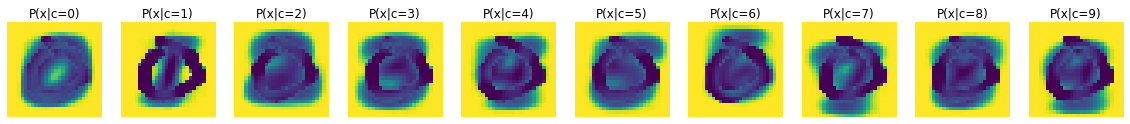

CORRECT CLASSIFY: Actucal label:1, classified label:1


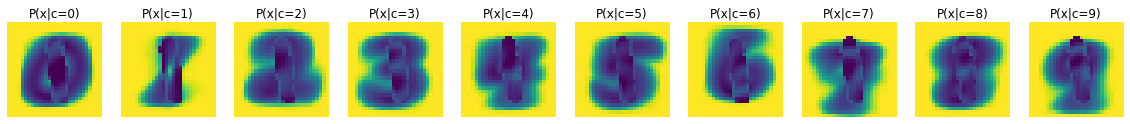

CORRECT CLASSIFY: Actucal label:2, classified label:2


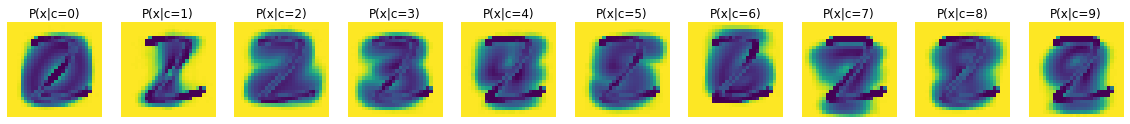

CORRECT CLASSIFY: Actucal label:3, classified label:3


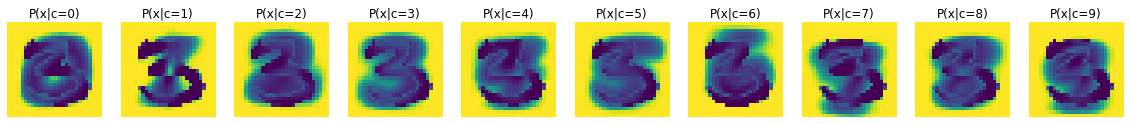

CORRECT CLASSIFY: Actucal label:4, classified label:4


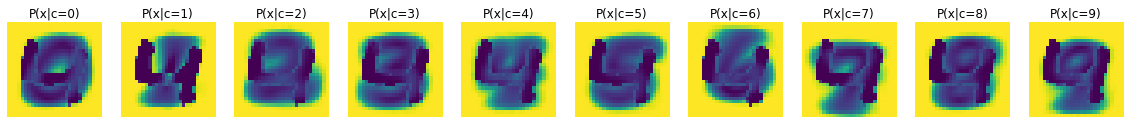

CORRECT CLASSIFY: Actucal label:5, classified label:5


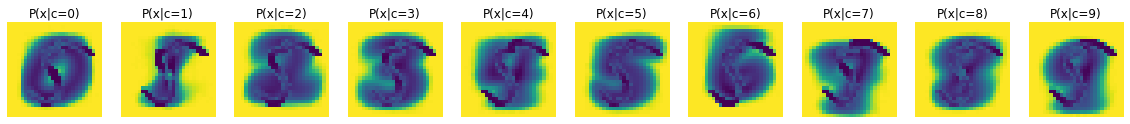

CORRECT CLASSIFY: Actucal label:6, classified label:6


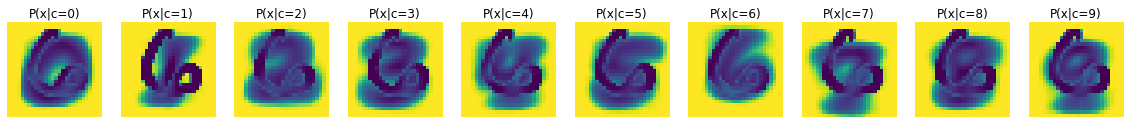

CORRECT CLASSIFY: Actucal label:7, classified label:7


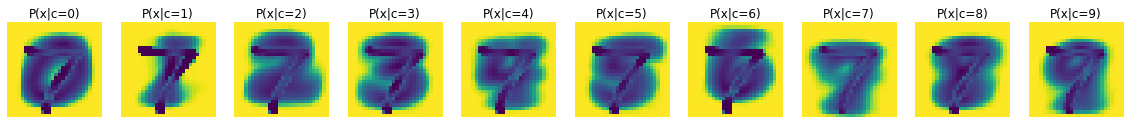

CORRECT CLASSIFY: Actucal label:8, classified label:8


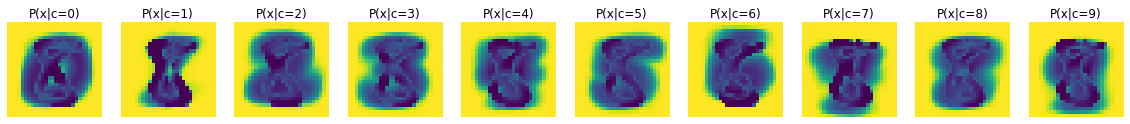

CORRECT CLASSIFY: Actucal label:9, classified label:9


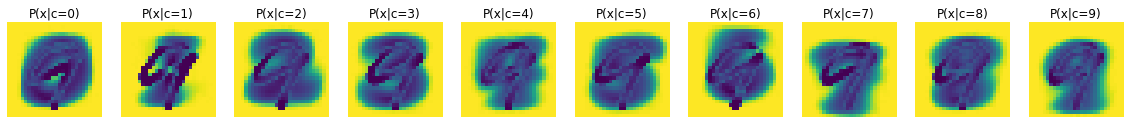

INCORRECT CLASSIFY: Actucal label:0, classified label:3


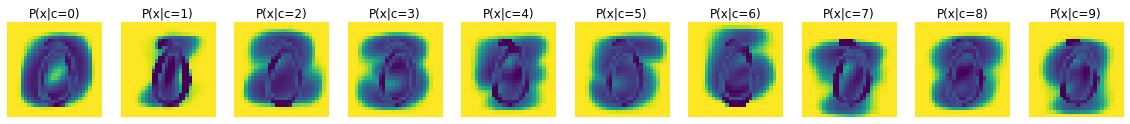

INCORRECT CLASSIFY: Actucal label:1, classified label:6


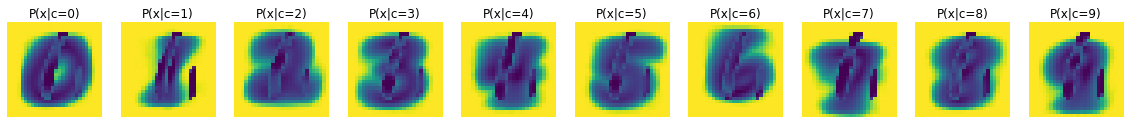

INCORRECT CLASSIFY: Actucal label:2, classified label:6


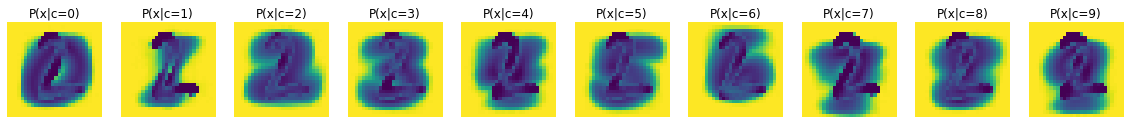

INCORRECT CLASSIFY: Actucal label:3, classified label:9


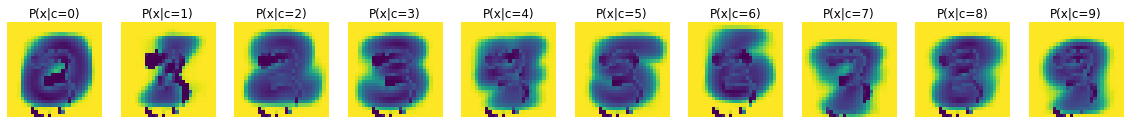

INCORRECT CLASSIFY: Actucal label:4, classified label:9


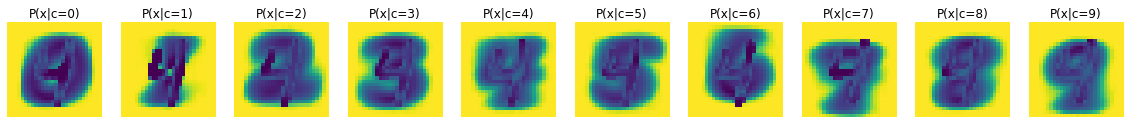

INCORRECT CLASSIFY: Actucal label:5, classified label:3


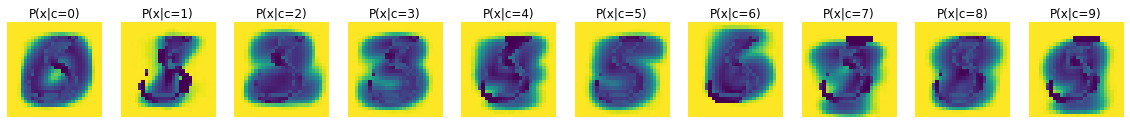

INCORRECT CLASSIFY: Actucal label:6, classified label:2


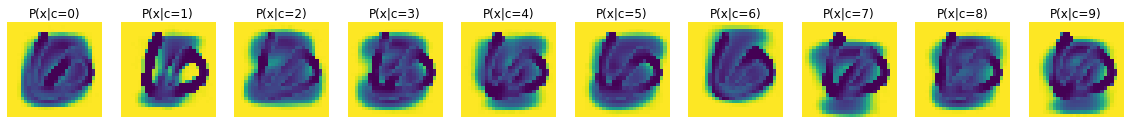

INCORRECT CLASSIFY: Actucal label:7, classified label:9


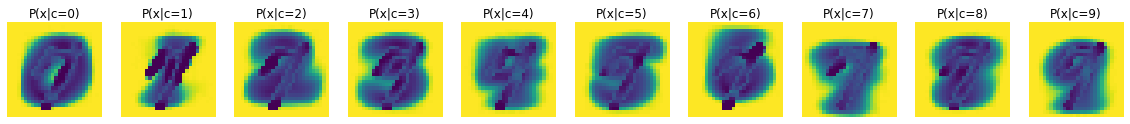

INCORRECT CLASSIFY: Actucal label:8, classified label:7


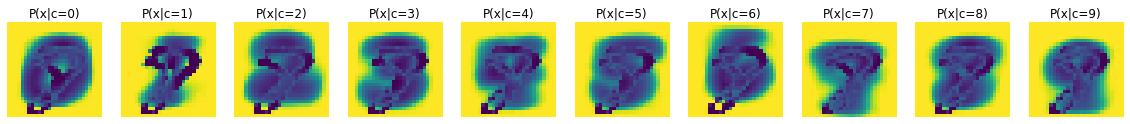

INCORRECT CLASSIFY: Actucal label:9, classified label:1


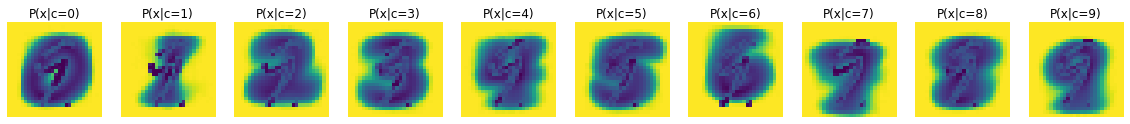

In [10]:
sub=nb.pred-test_label
rd_start=np.random.randint(len(sub)-1000) # random choice
count1,count2=0,0
for i in range(rd_start,len(sub),1):
    if sub[i]==0 and count1<10 and test_label[i]==count1 and test_label[i]==nb.pred[i]: # correct classify
        print("CORRECT CLASSIFY: Actucal label:%d, classified label:%d" %(test_label[i],nb.pred[i]))
        nb.show_image(nb.likelihood[i])
        count1+=1
    if count1>10 and count2>10:
        break
for i in range(rd_start,len(sub),1):
    if sub[i]!=0 and count2<10 and test_label[i]==count2 and test_label[i]!=nb.pred[i] : # incorrect classify
        print("INCORRECT CLASSIFY: Actucal label:%d, classified label:%d" %(test_label[i],nb.pred[i]))
        nb.show_image(nb.likelihood[i])
        count2+=1
    if count2>10:
        break

COMMENT : Based on the above image sets of correct classification and incorrect classification, we find that the classification is mainly influenced by the black label in the image, but it is also affected by the blue part. In addition, comparing images sets between classification and incorrect classification, we speculate that the label writing is also an important factor for classification. It can be seen that label writing in images of correct classifcation, the label writing is very clearly. When it comes to incorrect classification, the label writing is not clear. For example, the label in INCORRECT CLASSIFY: Acutal label:8 is very close to 7 with the influence of the blue background.

---
Part 2. Build a regularized logistic regression classifier using ridge (L2) regularization.

L2 regularized logistic regression uses: $$L(w) =  \sum_{i=1}^{N} log(1 + exp(-y_{i}w^{T}X_{i})) + \frac{\lambda}{2}||w||_{2}$$

The gradient descent update equation is: $$w_{t+1} = w_{t} \ - \ \eta_{t} \nabla L(w) $$

By taking the gradient of $\nabla L(w)$, we can obtain the following the gradient descent update equation for regulatized logistic regression, which is derivated base on the update equation for non-regularized logistic regression :$$\nabla L(w) =  \sum_{i=1}^{N} \frac{-y_{i}x_{i} \ exp(-y_{i}w^{T}x_{i})}{1 \ + exp(-y_{i}w^{T}x_{i})} \ + \ \lambda w \\= -\sum_{i=1}^{N} y_{i}x_{i}(1-p(y_i|x_i)) \ + \ \lambda w \\since \ \frac{\partial f}{\partial x}\frac{\lambda}{2}||w||_{2} = \frac{\partial f}{\partial x}\frac{\lambda}{2} w^{2} = \lambda w \\ p(y_i|x_i) = \frac{1}{1 \ + exp(-y_{i}w^{T}x_{i})}$$

Follow the gradient descent update equation to find the best $w$ and apply that classifier to the MNIST data set.

 - Encapsulate the Logistic Regression classifier to a class
 - "gradient_desc" function takes the features and labels to do the gradient descent for the update equatoin for regularizion logistic regression
 - "predict" function classifies the test input data. For each class, first, set up the training data as +1 for consistent digit, as -1 for different digit. Then compute the gradient descent update equatoin to get the final weight with lowest cost. Next, use the logistic probability function to get all the probability with different classes and predict the class with the maximum probability.
 - "L2_regularization" adds a regularization term to the loss function. Through setting the log scale of different lamdbas, we can get each weights and overall testing accuracy for each lambda. Then we can return the best lambda with maximum overall accuracy.
 - "confusion_matrix" gives the confusion matrix for the testing result, calculate the overall accuracy, accuracy for each digit, and plot corresponding tables.
 - "show_image" shows the weights of a class as an image with 28x28 scale

In [23]:
class logistic_regression:

    def gradient_desc(self,features,labels,lamd,iters):
        weights=np.reshape(np.ones(features.shape[1]),(1,features.shape[1])) #initialize weights reshape to 2d array 1*785
        eta=1.0/len(features) # approximately equal
        loss=[]
        for i in range(iters):
            p= 1.0/(1+np.exp(-np.multiply(labels.T,np.dot(features,weights.T)))) # probability
            nabla=-np.dot(np.multiply(labels,(1-p).T),features)+lamd*weights # distance of L(W)
            weights=weights-eta*nabla # update equation
            loss.append(np.linalg.norm(eta*nabla)) # compute the vector
        return weights, loss
    
    def predict(self,train_x,train_label,test_x,test_label,lamd,iters,all_w):
        train_x=np.column_stack((np.ones(len(train_x)),train_x)) #add a column of 1s at first as bias
        test_x=np.column_stack((np.ones(len(test_x)),test_x))
        train_x=train_x/255 # normalize traing data
        test_x=test_x/255 # normalize testing data
        all_weights=[]
        all_loss=[]
        n_class=np.unique(train_label)
        probs=np.zeros(shape=(len(test_x),len(n_class))) # 2d-array for store probability for each class for each test
        for i in range(len(n_class)):
            label_set = np.reshape(np.where(train_label == n_class[i], 1, -1), (1, train_label.shape[0])) # set the training label with +1 for class is c or -1 for class is not c
            gd=self.gradient_desc(train_x,label_set,lamd,iters) # weights
            weights=gd[0]
            all_loss.append(gd[1])
            all_weights.append(weights[0,:])
            pred_prob=1.0/(1+np.exp(-np.dot(test_x,weights.T)))
            probs[:,i]=pred_prob[:,0]  
            pred_class=np.argmax(probs,axis=1) # classifer with maximum probability
        if all_w: # if need all the weights for classes
            return pred_class,np.asarray(all_weights)
        return pred_class, all_loss
                       
    def L2_regularization(self,train_x,train_label,test_x,test_label,lamds,iters):
        test_accu_rate=[]
        for i in range(len(lamds)):
            pred=self.predict(train_x,train_label,test_x,test_label,lamds[i],iters, False) 
            pred_class=pred[0]
            all_loss=pred[1]
            all_accu=np.sum([pred_class==test_label])/len(test_label)*100 
            test_accu_rate.append(all_accu)
            self.converge(all_loss,lamds[i])
        
        fig=plt.figure(figsize=(7,4))
        bx=fig.add_axes([0,0,1,1])
        bx.plot(lamds,test_accu_rate,'-o')
        bx.set_xscale('log') # log scale of x axis
        bx.set_xlabel('L2 Regularization Lambda',fontsize=12)
        bx.set_ylabel('Accuary Rate %',fontsize=12)
        plt.title("Overall Test Accuracy versus Regularization")
        plt.show()
        
        best_accu_rate=np.max(test_accu_rate)
        best_lamd=lamds[np.argmax(test_accu_rate)]
        print("Best L2 regularization lambda is "+str(best_lamd)+" for overall accuracy %.2f%%." %(best_accu_rate))
        return best_lamd
    
    def confusion_matrix(self, actual, pred):
        cm=confusion_matrix(actual,pred)
        all_accu=(sum(np.diagonal(cm))/len(actual))*100 # all accuary, add all correct number in diagonal in confusion matrix
        n_class=np.unique(actual)
        digit_accu=np.zeros(shape=(len(n_class),2))
        for i in range(len(cm)):
            digit_accu[i,0]=n_class[i]
            digit_accu[i,1]=round(cm[i,i]/np.sum(cm[i,:])*100,2) # digit accuary, correct divided by all number for a digit
        
        print("Logistic Regression Confusion Matrix (Actual vs. Prediction)")
        ax=plt.subplot()
        columns=[]
        rows=[]
        colors=[]
        for i in n_class:
            columns.append(i)
            rows.append(i)
            colors.append("#E0E0E0")
        cm_table=ax.table(cellText=cm,colLabels=columns,rowLabels=rows,loc='center',colColours=colors, rowColours=colors)
        cm_table.auto_set_font_size(False)
        cm_table.set_fontsize(12)
        cm_table.scale(1.2, 3)
        ax.axis("off")
        plt.show()
        
        print("Logistic Regression Digit Accuracy")
        bx=plt.subplot()
        columns=["Digit","Accuracy for Each Digit %"]
        digit_table=bx.table(cellText=digit_accu,colLabels=columns,loc='center',colColours=colors)
        digit_table.auto_set_font_size(False)
        digit_table.set_fontsize(12)
        digit_table.scale(1,2)
        bx.axis("off")
        plt.show()
        
        print("Logistic Regression Overall Accuracy: %.2f%%" %(all_accu))
    
    def converge(self,all_loss,lamd):
        classes=[]
        for i in range(10):
            classes.append("class "+str(i)) 
        plt.subplots(figsize=(12, 5))
        for i in range(len(all_loss)):
            plt.semilogx(all_loss[i], label=classes[i])
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Gradient Descent Trend with L2 lambda="+str(lamd))
        plt.show()    
    
    def show_image(self,imageData):
        classes=[]
        for i in range(10):
            classes.append("c = "+str(i))    
        plt.subplots(figsize=(20,2))
        for i in range(len(classes)):
            plt.subplot(1,len(classes),i+1)
            plt.imshow(imageData[i].reshape((28,28))) # reshape the prob to 28*28 image
            plt.axis("off")
            plt.title(classes[i])
        
        plt.show()

---
Plot the gradient descent trend for each class for different lambdas with L2 regularization. We compute the loss based on each update of the weights. In order to reduce fluctuation, we aslo normalize the traing data and testing testing by the maximum pixel number, and initially set the iterations to 1000. At last, we also plot the overall test accuracy versus the regularization value where a log-scale is used for regularization value. We set 1000 iterations for gradient desenct. 

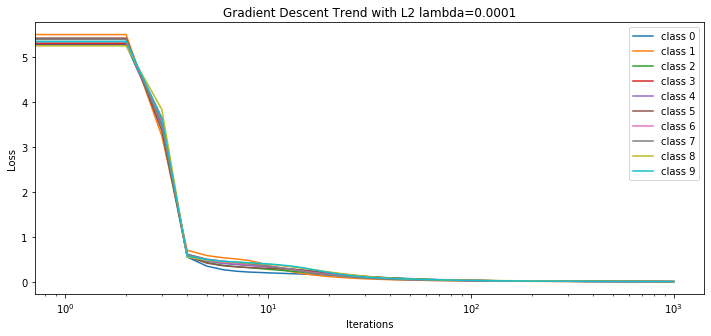

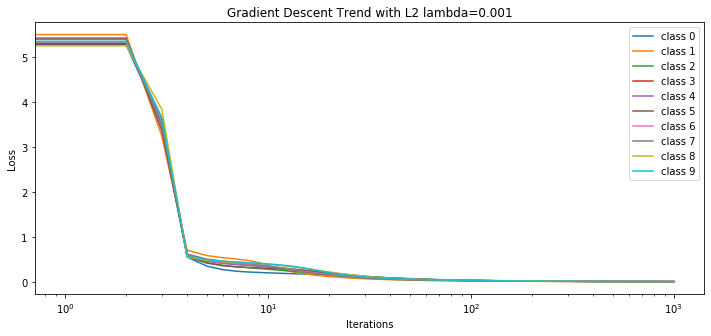

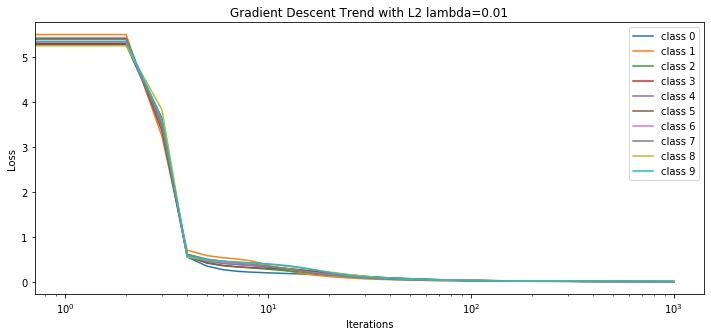

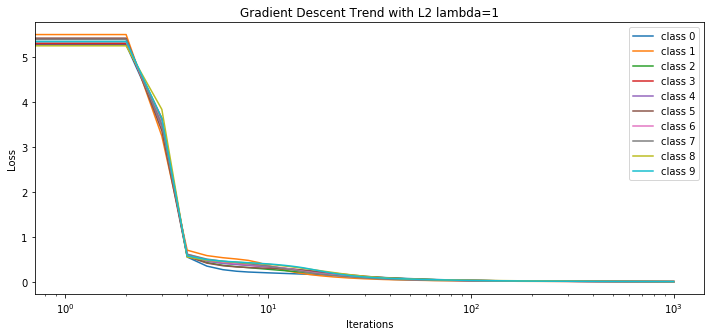

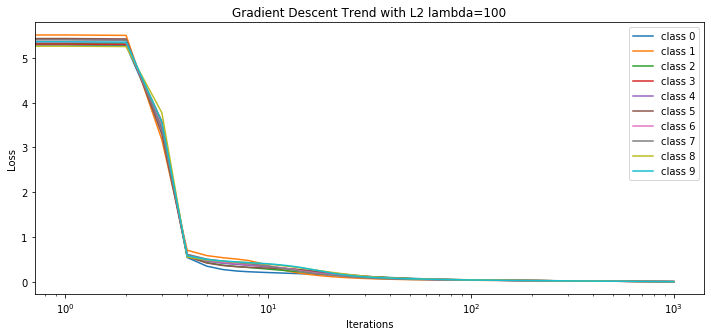

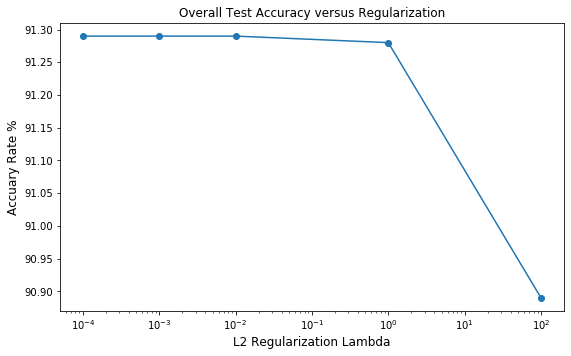

Best L2 regularization lambda is 0.0001 for overall accuracy 91.29%.


In [24]:
lr_l2=logistic_regression()
lambdas=[0.0001,0.001,0.01,1,100] # log scale for lambdas 
iterations=1000
best_lambda=lr_l2.L2_regularization(trainX, train_label, testX, test_label,lambdas,iterations)


The first 5 figures give the gradient descent ternd for different lambdas with L2 regularization. In each figure, x-axis is the iteration times, y-axis is the loss. The last figure shows the overall testing accuracy versus L2 regularization values. x-axis is the L2 regularization value, y-axis is the corresponding accuracy rate. We can find that small lambda has a higher accuracy rate, large lambda has a very lower accuracy.

---
Based on the obversation above, we choose iterations to 100 and lambda to 0.0001 to predict the testing data and provide a confusion matrix, accuracy for each digit, and overall accuracy. (We also test for 1000 iterations. The is no differnce fo overall accuracy.) The confusion matrix summaries the prediction results on this classifier. Overall accurancy is based on the diagonal data in confusion matrix since the diagonal is the correct classifier for each class. Digit accurancy is also based on the rows in confusion matrix because the summation of a row the total number that a class appeared in the testing data.

Logistic Regression Confusion Matrix (Actual vs. Prediction)


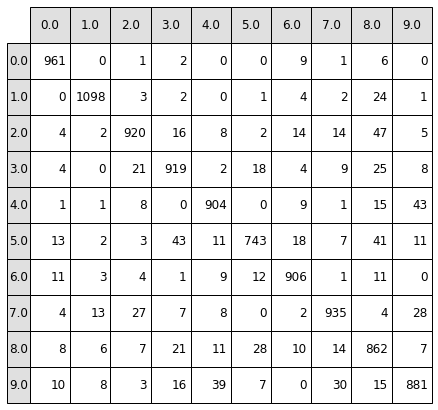

Logistic Regression Digit Accuracy


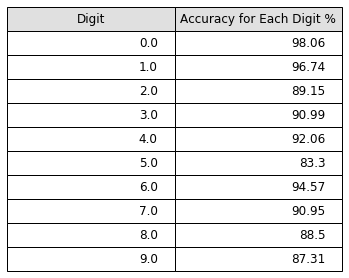

Logistic Regression Overall Accuracy: 91.29%


In [25]:
lr=logistic_regression()
iteration=100
pred,all_weights=lr.predict(trainX, train_label, testX, test_label,best_lambda,iterations, True)
lr.confusion_matrix(test_label,pred)


The first table is confusion matrix. The confusion matrix summaries the prediction results on this classifier. The number of correct and incorrect predictions are summarized with count values and broken down by each class. Each row of the matrix corresponds to a predicted class, each column of the matrix corresponds to an actual class. 

The second table is the accuracy for each digit, each row is the digit number and its accuracy in percentage.

COMMENT : When we set a small learning rate and a samll lambda for regularization. We can find that, compared with Naive Bayes classification, Logistic Regerssion has a better performance. The range of accurancy for each digit is smaller, which means that this classifier is more stable. In addition, the overall accurancy, 91.29%, is better than Naive Bayes. All data above showes that logistic regeression has a better classification performance.

---
For each of 10 trained classifiers, show an image of the 784 weights (exclude bias weight) as a 28 × 28 image.

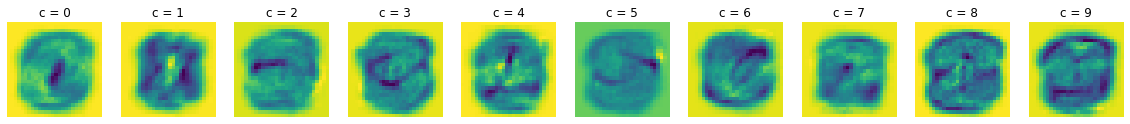

In [26]:
lr.show_image(all_weights[:,1:]) # show image of each weights, exclude bias weight

COMMENT : Combining with the accuracy of each digit and the image of the 784 weights, we can have speculation of how the classifier works. For example of c=0 and c=5, which is the highest accurancy and lowest accurancy respectively. For c=0, the image of weights shows as 0 very cleayly, and the difference of weight among pixels is very sharp. When it comes to 5, it hard to figure out what's the label is. In addition, the difference of wight among pixels is smooth.
So we can sepculate that we allocate weight to each pixel by training. After training, if the figure of weight image is more close to the aim label, we will have higher accurancy.